In [69]:
# Install the Cassandra python driver
!pip install cassandra-driver

In [70]:
# Import the necessary libraries
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import json

In [71]:


cloud_config= {
  'secure_connect_bundle': 'secure-connect-big-data.zip'
}


with open("big_data-token.json") as f:
    secrets = json.load(f)

CLIENT_ID = secrets["clientId"]
CLIENT_SECRET = secrets["secret"]

auth_provider = PlainTextAuthProvider(CLIENT_ID, CLIENT_SECRET)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

if session:
  print('Connected!')
else:
  print("An error occurred.")

Connected!


In [72]:
# load csv data into cassandra
# Connect to the big_data Keyspace
session = cluster.connect()

# Load the CSV data into a pandas DataFrame
import pandas as pd
df = pd.read_csv('tripdata.csv')
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")


The dataset has 284042 rows and 13 columns.


In [73]:
session.execute("""
    CREATE TABLE IF NOT EXISTS big_data_asgn.bike_trips (
        ended_at timestamp,
        start_station_name text,
        start_station_id text,
        end_station_name text,
        end_station_id text,
        start_lat float,
        start_lng float,
        end_lat float,
        end_lng float,
        member_casual text,
        PRIMARY KEY ((start_station_id), ended_at)
    )
""")


In [74]:
#  insert query
insert_query = session.prepare("""
    INSERT INTO big_data_asgn.bike_trips (
        ended_at, start_station_name, start_station_id, end_station_name,
        end_station_id, start_lat, start_lng, end_lat, end_lng, member_casual
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
""")

# Convert date strings to datetime for `ended_at` column
df['ended_at'] = pd.to_datetime(df['ended_at'], errors='coerce')

#  handle missing values
text_columns = [
    'start_station_name', 'start_station_id',
    'end_station_name', 'end_station_id', 'member_casual'
]

for col in text_columns:
    df[col] = df[col].astype(str).fillna('N/A')

# Ensure latitude and longitude columns are floats
float_columns = ['start_lat', 'start_lng', 'end_lat', 'end_lng']
for col in float_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with any critical missing data
df = df.dropna(subset=['ended_at', 'start_station_id', 'end_station_id'])


df_subset = df.head(100)

# Insert rows into the Cassandra table
for index, row in df_subset.iterrows():
    session.execute(insert_query, (
        row['ended_at'],
        row['start_station_name'],
        row['start_station_id'],
        row['end_station_name'],
        row['end_station_id'],
        float(row['start_lat']),
        float(row['start_lng']),
        float(row['end_lat']),
        float(row['end_lng']),
        row['member_casual']
    ))

print("Data inserted successfully.")


Data inserted successfully.


In [75]:
# Select the data from the bike_trips table
rows = session.execute("SELECT * FROM big_data_asgn.bike_trips")

for row in rows:
    print(
        row.ended_at,
        row.start_station_name,
        row.start_station_id,
        row.end_station_name,
        row.end_station_id,
        row.start_lat,
        row.start_lng,
        row.end_lat,
        row.end_lng,
        row.member_casual
    )



Streaming output truncated to the last 5000 lines.
2022-03-14 20:41:38 Broadway & Belmont Ave 13277 Wilton Ave & Belmont Ave TA1307000134 41.94007110595703 -87.6455078125 41.940181732177734 -87.65303802490234 member
2022-03-16 08:31:46 Broadway & Belmont Ave 13277 Clark St & Lake St KA1503000012 41.94010543823242 -87.64545440673828 41.88602066040039 -87.63087463378906 member
2022-03-16 19:59:09 Broadway & Belmont Ave 13277 Franklin St & Chicago Ave 13017 41.94010543823242 -87.64545440673828 41.89674758911133 -87.63566589355469 member
2022-03-17 09:01:04 Broadway & Belmont Ave 13277 Ravenswood Ave & Irving Park Rd TA1307000149 41.94015884399414 -87.64541625976562 41.954689025878906 -87.6739273071289 member
2022-03-17 17:12:06 Broadway & Belmont Ave 13277 Honore St & Division St TA1305000034 41.94010543823242 -87.64545440673828 41.90311813354492 -87.67393493652344 member
2022-03-17 20:53:16 Broadway & Belmont Ave 13277 Hampden Ct & Diversey Ave 202480.0 41.94007873535156 -87.645401000976

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [62]:
# Load the CSV file
data = pd.read_csv("tripdata.csv")

# Preview the data
data.head()


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,47EC0A7F82E65D52,classic_bike,2022-03-21 13:45:01,2022-03-21 13:51:18,Wabash Ave & Wacker Pl,TA1307000131,Kingsbury St & Kinzie St,KA1503000043,41.886875,-87.626030,41.889177,-87.638506,member
1,8494861979B0F477,electric_bike,2022-03-16 09:37:16,2022-03-16 09:43:34,Michigan Ave & Oak St,13042,Orleans St & Chestnut St (NEXT Apts),620,41.900998,-87.623752,41.898203,-87.637536,member
2,EFE527AF80B66109,classic_bike,2022-03-23 19:52:02,2022-03-23 19:54:48,Broadway & Berwyn Ave,13109,Broadway & Ridge Ave,15578,41.978353,-87.659753,41.984045,-87.660274,member
3,9F446FD9DEE3F389,classic_bike,2022-03-01 19:12:26,2022-03-01 19:22:14,Wabash Ave & Wacker Pl,TA1307000131,Franklin St & Jackson Blvd,TA1305000025,41.886875,-87.626030,41.877708,-87.635321,member
4,431128AD9AFFEDC0,classic_bike,2022-03-21 18:37:01,2022-03-21 19:19:11,DuSable Lake Shore Dr & North Blvd,LF-005,Loomis St & Jackson Blvd,13206,41.911722,-87.626804,41.877945,-87.662007,member


In [77]:
# Convert date columns to datetime
data['started_at'] = pd.to_datetime(data['started_at'])
data['ended_at'] = pd.to_datetime(data['ended_at'])

# Add duration column (in minutes)
data['ride_duration'] = (data['ended_at'] - data['started_at']).dt.total_seconds() / 60

# Extract additional features
data['month'] = data['started_at'].dt.month
data['day_of_week'] = data['started_at'].dt.day_name()
data['season'] = data['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

data['hour'] = data['started_at'].dt.hour

# Preview cleaned data
data.head()


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration,month,day_of_week,season,hour
0,47EC0A7F82E65D52,classic_bike,2022-03-21 13:45:01,2022-03-21 13:51:18,Wabash Ave & Wacker Pl,TA1307000131,Kingsbury St & Kinzie St,KA1503000043,41.886875,-87.626030,41.889177,-87.638506,member,6.283333,3,Monday,Spring,13
1,8494861979B0F477,electric_bike,2022-03-16 09:37:16,2022-03-16 09:43:34,Michigan Ave & Oak St,13042,Orleans St & Chestnut St (NEXT Apts),620,41.900998,-87.623752,41.898203,-87.637536,member,6.300000,3,Wednesday,Spring,9
2,EFE527AF80B66109,classic_bike,2022-03-23 19:52:02,2022-03-23 19:54:48,Broadway & Berwyn Ave,13109,Broadway & Ridge Ave,15578,41.978353,-87.659753,41.984045,-87.660274,member,2.766667,3,Wednesday,Spring,19
3,9F446FD9DEE3F389,classic_bike,2022-03-01 19:12:26,2022-03-01 19:22:14,Wabash Ave & Wacker Pl,TA1307000131,Franklin St & Jackson Blvd,TA1305000025,41.886875,-87.626030,41.877708,-87.635321,member,9.800000,3,Tuesday,Spring,19
4,431128AD9AFFEDC0,classic_bike,2022-03-21 18:37:01,2022-03-21 19:19:11,DuSable Lake Shore Dr & North Blvd,LF-005,Loomis St & Jackson Blvd,13206,41.911722,-87.626804,41.877945,-87.662007,member,42.166667,3,Monday,Spring,18


In [78]:
# Summary statistics for ride duration
print("Summary Statistics for Ride Duration:")
print(data['ride_duration'].describe())

# Breakdown by user type
print("\nRide Duration by User Type:")
print(data.groupby('member_casual')['ride_duration'].describe())


Summary Statistics for Ride Duration:
count    284042.000000
mean         18.497246
std         146.919041
min          -5.933333
25%           5.350000
50%           9.483333
75%          17.600000
max       34354.066667
Name: ride_duration, dtype: float64

Ride Duration by User Type:
                  count       mean        std       min       25%        50%  \
member_casual                                                                  
casual          89882.0  32.622390  257.28501 -5.933333  7.816667  14.216667   
member         194160.0  11.958329   28.26572  0.000000  4.716667   8.033333   

                     75%           max  
member_casual                           
casual         27.116667  34354.066667  
member         14.083333   1559.900000  


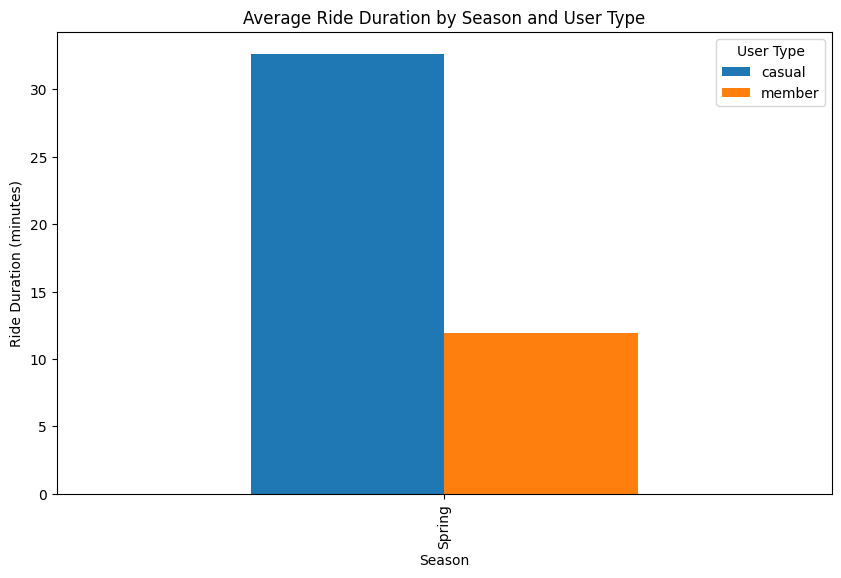

In [79]:
# Average ride duration by season and user type
season_duration = data.groupby(['season', 'member_casual'])['ride_duration'].mean().unstack()

# Plot the results
season_duration.plot(kind='bar', figsize=(10, 6))
plt.title('Average Ride Duration by Season and User Type')
plt.ylabel('Ride Duration (minutes)')
plt.xlabel('Season')
plt.legend(title='User Type')
plt.show()


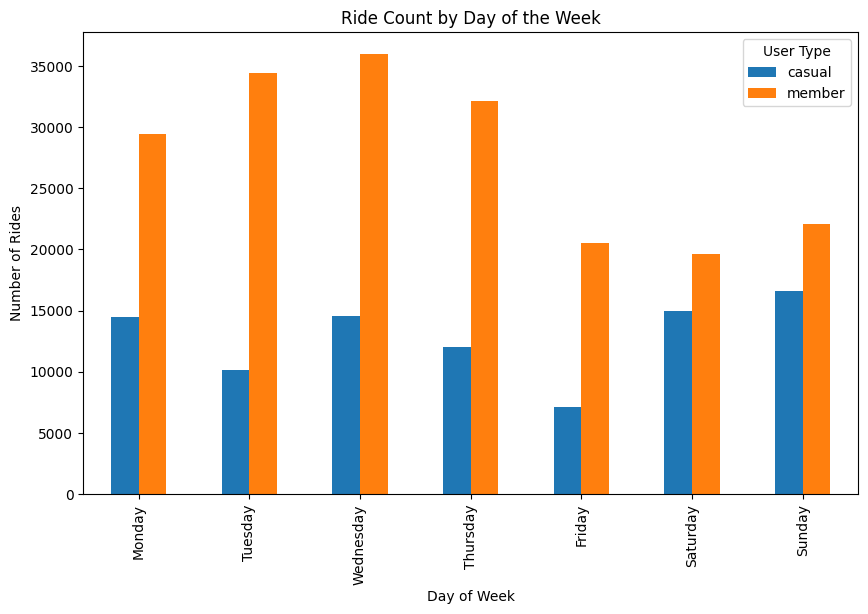

In [80]:
# Ride count by day of the week and user type
day_counts = data.groupby(['day_of_week', 'member_casual']).size().unstack()

# Sort by weekday order
day_counts = day_counts.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot the results
day_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Ride Count by Day of the Week')
plt.ylabel('Number of Rides')
plt.xlabel('Day of Week')
plt.legend(title='User Type')
plt.show()


In [81]:
# Most popular start stations by user type
popular_stations = data.groupby(['start_station_name', 'member_casual']).size().unstack().fillna(0)

# Top 10 stations for members
print("Top 10 Stations for Members:")
print(popular_stations['member'].sort_values(ascending=False).head(10))

# Top 10 stations for casual users
print("\nTop 10 Stations for Casual Users:")
print(popular_stations['casual'].sort_values(ascending=False).head(10))


Top 10 Stations for Members:
start_station_name
Kingsbury St & Kinzie St        1766.0
University Ave & 57th St        1431.0
Clinton St & Washington Blvd    1420.0
Ellis Ave & 60th St             1409.0
Clark St & Elm St               1396.0
Clinton St & Madison St         1333.0
Wells St & Concord Ln           1158.0
Dearborn St & Erie St           1133.0
Wells St & Elm St               1132.0
Canal St & Adams St             1083.0
Name: member, dtype: float64

Top 10 Stations for Casual Users:
start_station_name
Streeter Dr & Grand Ave               2399.0
DuSable Lake Shore Dr & Monroe St     1436.0
Millennium Park                       1161.0
Shedd Aquarium                         938.0
Michigan Ave & Oak St                  777.0
DuSable Lake Shore Dr & North Blvd     632.0
Theater on the Lake                    593.0
Indiana Ave & Roosevelt Rd             564.0
Wells St & Concord Ln                  534.0
Michigan Ave & Washington St           531.0
Name: casual, dtype: float64


<Figure size 1200x600 with 0 Axes>

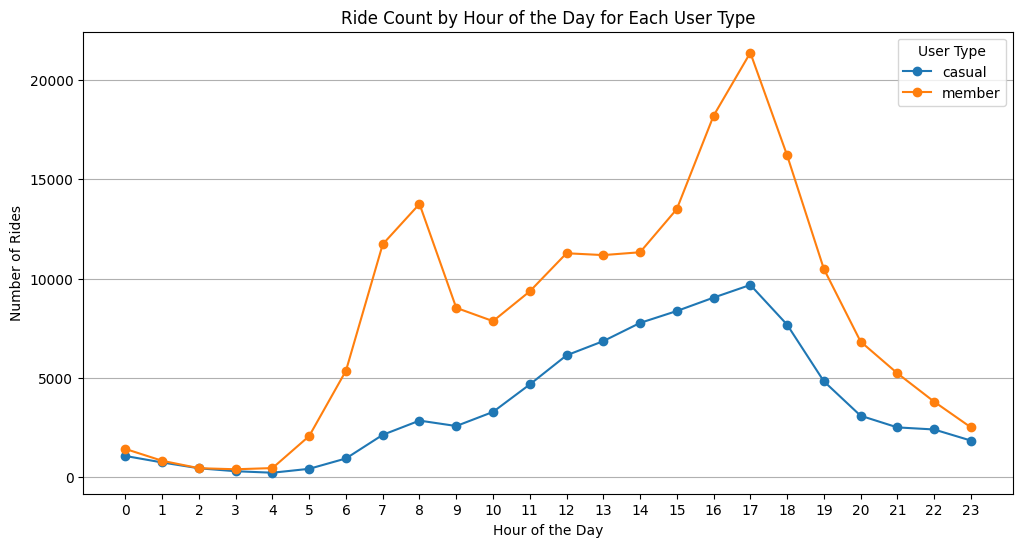

In [82]:
# Count of rides by hour and user type
hourly_rides = data.groupby(['hour', 'member_casual']).size().unstack()

# Plot the results
plt.figure(figsize=(12, 6))
hourly_rides.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Ride Count by Hour of the Day for Each User Type')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')
plt.xticks(range(0, 24))
plt.grid(axis='y')
plt.legend(title='User Type')
plt.show()
